In [1]:
import os

In [2]:
os.chdir('../')

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model as tfk__load_model

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 0 1 0 1 1 2 0 2 1 0 1 0 1 1 0 1 0 0 2 1 1 0 1 0 0 2 0]


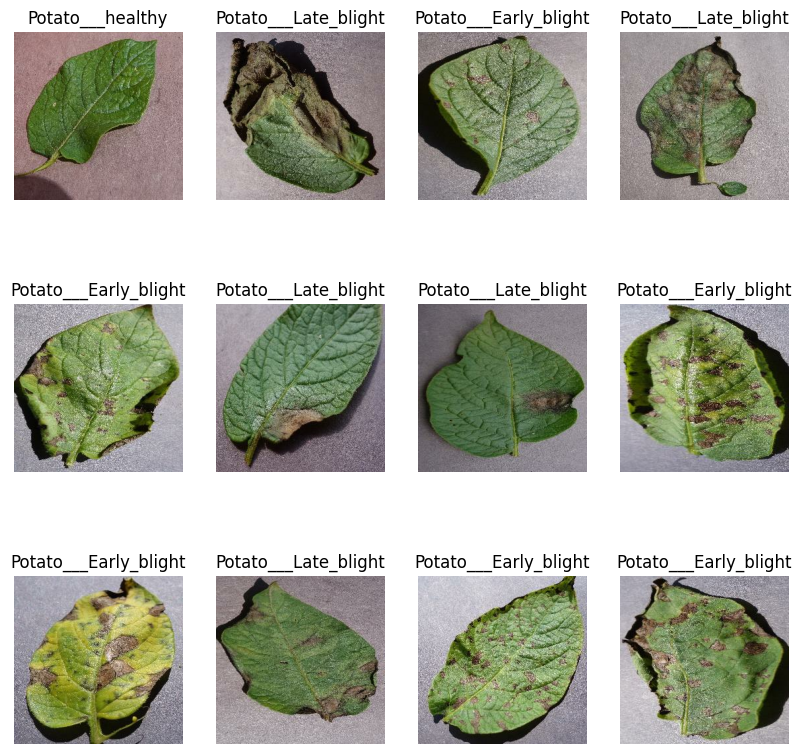

In [8]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [9]:
len(dataset)

68

In [10]:
EPOCHS = 50

In [11]:
train_size = 0.8
round(len(dataset)*train_size)

54

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
type(test_ds.take(1))

tensorflow.python.data.ops.take_op._TakeDataset

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
CHANNELS =3

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 315s 5s/step - loss: 0.9261 - accuracy: 0.4769 - val_loss: 0.8896 - val_accuracy: 0.5677
Epoch 2/50
54/54 [==============================] - 151s 3s/step - loss: 0.7099 - accuracy: 0.6730 - val_loss: 0.5390 - val_accuracy: 0.7188
Epoch 3/50
54/54 [==============================] - 148s 3s/step - loss: 0.3763 - accuracy: 0.8472 - val_loss: 0.2988 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 148s 3s/step - loss: 0.2978 - accuracy: 0.8785 - val_loss: 0.1600 - val_accuracy: 0.9531
Epoch 5/50
54/54 [==============================] - 150s 3s/step - loss: 0.2109 - accuracy: 0.9196 - val_loss: 0.1613 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 2315s 44s/step - loss: 0.1953 - accuracy: 0.9248 - val_loss: 0.1146 - val_accuracy: 0.9531
Epoch 7/50
54/54 [==============================] - 155s 3s/step - loss: 0.1691 - accuracy: 0.9340 - val_loss: 0.0663 - val_accuracy: 0.9844
Epoch 8/50


In [29]:
model.save('./artifacts/model.h5')

c:\Users\USER\anaconda3\envs\potatoDisease\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
#import pickle

In [31]:
# with open('./artifacts/trained_model.pkl',"wb") as model_obj:
#     pickle.dump(model,model_obj)

In [32]:
# with open('./artifacts/trained_model.pkl','rb') as model_read_obj:
#     model = pickle.load(model_read_obj)

In [33]:
model = tfk__load_model('./artifacts/model.h5')

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 5s 5s/step
predicted label: Potato___Early_blight


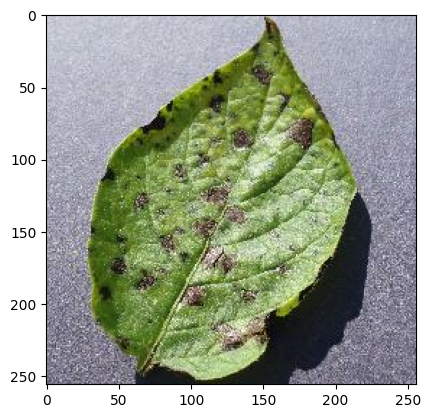

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 139ms/step


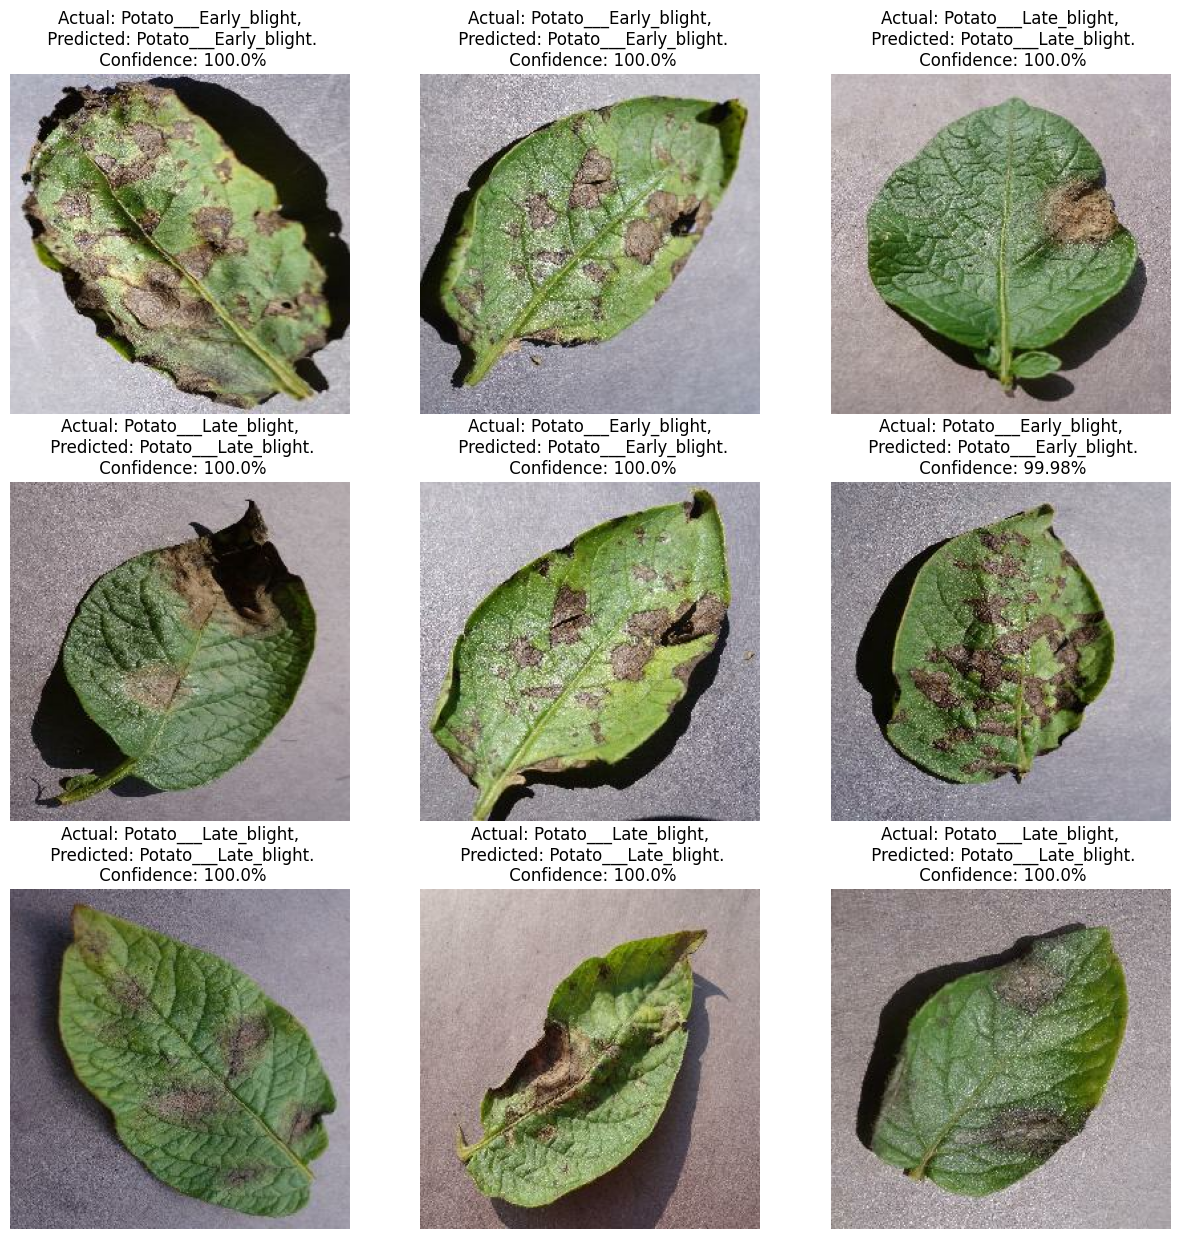

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
for im,lab in test_ds.take(1):
    for i in range(5):
        #print(im[i].numpy())
        img_array = tf.keras.preprocessing.image.img_to_array(im[i].numpy())
        print(img_array)
        print('++++++++++++++++++++++++++++++')
        img_array = tf.expand_dims(img_array, 0)
        print(img_array)
        print()
        print('*****************************')

[[[203. 205. 217.]
  [198. 200. 212.]
  [193. 195. 207.]
  ...
  [165. 168. 185.]
  [161. 164. 181.]
  [166. 169. 186.]]

 [[217. 219. 231.]
  [210. 212. 224.]
  [196. 198. 210.]
  ...
  [166. 169. 186.]
  [170. 173. 190.]
  [169. 172. 189.]]

 [[185. 187. 199.]
  [197. 199. 211.]
  [200. 202. 214.]
  ...
  [178. 181. 198.]
  [189. 192. 209.]
  [179. 182. 199.]]

 ...

 [[138. 135. 154.]
  [109. 106. 125.]
  [ 91.  88. 107.]
  ...
  [136. 133. 152.]
  [132. 129. 148.]
  [179. 176. 195.]]

 [[ 98.  95. 114.]
  [107. 104. 123.]
  [ 74.  71.  90.]
  ...
  [159. 156. 175.]
  [105. 102. 121.]
  [151. 148. 167.]]

 [[116. 113. 132.]
  [104. 101. 120.]
  [126. 123. 142.]
  ...
  [120. 117. 136.]
  [165. 162. 181.]
  [169. 166. 185.]]]
++++++++++++++++++++++++++++++
tf.Tensor(
[[[[203. 205. 217.]
   [198. 200. 212.]
   [193. 195. 207.]
   ...
   [165. 168. 185.]
   [161. 164. 181.]
   [166. 169. 186.]]

  [[217. 219. 231.]
   [210. 212. 224.]
   [196. 198. 210.]
   ...
   [166. 169. 186.]
   [